In [ ]:
# load and check DeepSTARR test set

from evoaug_utils import utils

data_path = '/grid/wsbs/home_norepl/pmantill/train_EvoAug/deepstarr-data.h5'

batch_size = 128
base_dataset = utils.H5Dataset(data_path, batch_size=batch_size, lower_case=False, transpose=False)

print("\nTest Set Dimensions:")
print(f"x_test shape: {base_dataset.x_test.shape}")
print(f"y_test shape: {base_dataset.y_test.shape}")


Test Set Dimensions:
x_test shape: torch.Size([41186, 4, 249])
y_test shape: torch.Size([41186, 2])


In [ ]:
# Get GPU - been connecting via ssh to my gpu node
import torch
print(f'GPU detected: {torch.cuda.is_available()}')

GPU detected: True


In [25]:
# Load EvoAug DeepSTARR student model and compute test MSE and Pearson r (Dev, Hk)
# Use pylightning student architecture from distill_EvoAug2.py

import os
import torch
import numpy as np
from scipy import stats
from distill_EvoAug2 import UncertaintyAwareStudent, UncertaintyAwareLightningModel
from evoaug_utils.model_zoo import DeepSTARR 

# Paths
output_dir = '/grid/wsbs/home_norepl/pmantill/train_EvoAug/EvoAug_ensemble_10'
student_ckpt = os.path.join(output_dir, 'uncertainty_student.ckpt')

# Build a minimal "teacher" with just the DeepSTARR architecture (no weights)
teacher_model = type("Teacher", (), {"model": DeepSTARR(2)})()

# Build student and load trained weights
student_model = UncertaintyAwareStudent(teacher_model, num_tasks=2)
lightning_student = UncertaintyAwareLightningModel.load_from_checkpoint(student_ckpt, student_model=student_model)

# Device + eval
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lightning_student.to(device).eval()

print("Student model loaded successfully")

Student model loaded successfully


In [42]:
# Full-test predictions (mean head) and metrics.
# Save predictions and actual labels

with torch.no_grad():
    y_preds = []
    y_trues = []
    for x, y in base_dataset.test_dataloader():
        x = x.to(device).float()
        out = lightning_student(x)
        y_preds.append(out['mean'].cpu())
        y_trues.append(y)
    y_pred = torch.cat(y_preds, dim=0).numpy()
    y_true = torch.cat(y_trues, dim=0).numpy()

# MSE per task
mse_dev = np.mean((y_pred[:, 0] - y_true[:, 0])**2)
mse_hk  = np.mean((y_pred[:, 1] - y_true[:, 1])**2)

# Pearson r per task
r_dev = stats.pearsonr(y_pred[:, 0], y_true[:, 0])[0]
r_hk  = stats.pearsonr(y_pred[:, 1], y_true[:, 1])[0]

# Spearman rho per task
rho_dev = stats.spearmanr(y_pred[:, 0], y_true[:, 0])[0]
rho_hk  = stats.spearmanr(y_pred[:, 1], y_true[:, 1])[0]

print("Student model metrics:")
print(f"Dev - MSE: {mse_dev:.4f}, Pearson r: {r_dev:.4f}, Spearman rho: {rho_dev:.4f}")
print(f"HK  - MSE: {mse_hk:.4f}, Pearson r: {r_hk:.4f}, Spearman rho: {rho_hk:.4f}")

# Build full test-set DataFrames for plotting
import pandas as pd
num_samples = y_true.shape[0]
import numpy as np
indices = np.arange(num_samples)

dev_df = pd.DataFrame({
    'index': indices,
    'actual_dev': y_true[:, 0],
    'pred_dev': y_pred[:, 0]
})

hk_df = pd.DataFrame({
    'index': indices,
    'actual_hk': y_true[:, 1],
    'pred_hk': y_pred[:, 1]
})

Student model metrics:
Dev - MSE: 1.1924, Pearson r: 0.7013, Spearman rho: 0.6703
HK  - MSE: 1.1400, Pearson r: 0.7795, Spearman rho: 0.5967


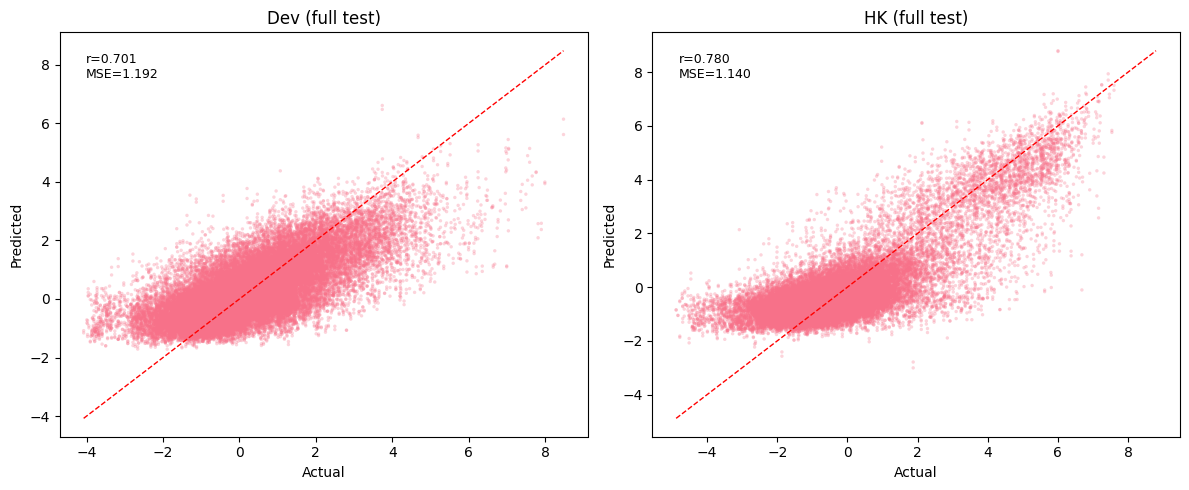

Saved: /grid/wsbs/home_norepl/pmantill/train_EvoAug/EvoAug_ensemble_10/pred_vs_actual_all.svg


In [44]:
# Plot predicted vs actual for all sequences in test set

import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def scatter_pred_vs_actual(ax, df, actual_col, pred_col, title):
    x = df[actual_col].values
    y = df[pred_col].values
    ax.scatter(x, y, s=6, alpha=0.3, edgecolor='none')
    vmin = float(min(x.min(), y.min()))
    vmax = float(max(x.max(), y.max()))
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(title)
    # Metrics annotation
    mse = np.mean((y - x) ** 2)
    r = np.corrcoef(x, y)[0, 1]
    ax.text(0.05, 0.95, f"r={r:.3f}\nMSE={mse:.3f}", transform=ax.transAxes,
            ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, linewidth=0))

scatter_pred_vs_actual(axes[0], dev_df, 'actual_dev', 'pred_dev', 'Dev (full test)')
scatter_pred_vs_actual(axes[1], hk_df, 'actual_hk', 'pred_hk', 'HK (full test)')

plt.tight_layout()
plot_path = os.path.join(output_dir, 'pred_vs_actual_all.svg')
plt.savefig(plot_path, format='svg', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {plot_path}")

In [ ]:
# Get high-activity test indices per task (no sequence conversion)
# High activity defined as (actual > 2.0) AND (predicted > 2.0)

import os
import numpy as np
import pandas as pd
from scipy import stats

threshold = 2.0

# Ensure y_pred and y_true exist from previous cell
assert 'y_pred' in globals() and 'y_true' in globals(), "Run the metrics cell first to compute y_pred/y_true."

# Dev (task 0): AND condition
mask_dev = (y_true[:, 0] > threshold) & (y_pred[:, 0] > threshold)
idx_dev = np.where(mask_dev)[0]
high_dev_df = pd.DataFrame({
    'index': idx_dev,
    'actual_dev': y_true[idx_dev, 0],
    'pred_dev': y_pred[idx_dev, 0]
}).sort_values('actual_dev', ascending=False).reset_index(drop=True)

# HK (task 1): AND condition
mask_hk = (y_true[:, 1] > threshold) & (y_pred[:, 1] > threshold)
idx_hk = np.where(mask_hk)[0]
high_hk_df = pd.DataFrame({
    'index': idx_hk,
    'actual_hk': y_true[idx_hk, 1],
    'pred_hk': y_pred[idx_hk, 1]
}).sort_values('actual_hk', ascending=False).reset_index(drop=True)

# Save to CSV in output_dir
high_dev_path = os.path.join(output_dir, 'high_activity_dev.csv')
high_hk_path = os.path.join(output_dir, 'high_activity_hk.csv')
high_dev_df.to_csv(high_dev_path, index=False)
high_hk_df.to_csv(high_hk_path, index=False)

# Recompute metrics on filtered subsets only
pred_dev_f = high_dev_df['pred_dev'].values
true_dev_f = high_dev_df['actual_dev'].values
pred_hk_f  = high_hk_df['pred_hk'].values
true_hk_f  = high_hk_df['actual_hk'].values

mse_dev_f = np.mean((pred_dev_f - true_dev_f)**2) if len(pred_dev_f) > 0 else np.nan
mse_hk_f  = np.mean((pred_hk_f  - true_hk_f )**2) if len(pred_hk_f) > 0 else np.nan
r_dev_f   = stats.pearsonr(true_dev_f, pred_dev_f)[0] if len(pred_dev_f) > 1 else np.nan
r_hk_f    = stats.pearsonr(true_hk_f,  pred_hk_f )[0] if len(pred_hk_f) > 1 else np.nan
rho_dev_f = stats.spearmanr(true_dev_f, pred_dev_f)[0] if len(pred_dev_f) > 1 else np.nan
rho_hk_f  = stats.spearmanr(true_hk_f,  pred_hk_f )[0] if len(pred_hk_f) > 1 else np.nan

pct_dev = 100.0 * len(high_dev_df) / len(base_dataset.x_test)
pct_hk  = 100.0 * len(high_hk_df) / len(base_dataset.x_test)

print("High-activity sequences saved (actual & predicted > 2.0):")
print(f" Dev: {pct_dev:.2f}% (N={len(high_dev_df)})")
print(f" HK : {pct_hk:.2f}% (N={len(high_hk_df)})")

print(f" MSE_dev (filtered): {mse_dev_f:.4f}, Pearson r: {r_dev_f:.4f}, Spearman rho: {rho_dev_f:.4f}")
print(f" MSE_hk  (filtered): {mse_hk_f:.4f}, Pearson r: {r_hk_f:.4f}, Spearman rho: {rho_hk_f:.4f}")

High-activity sequences saved (actual & predicted > 2.0):
 Dev: 5.22% (N=2151)
 HK : 6.20% (N=2552)
 MSE_dev (filtered): 1.5328, Pearson r: 0.4348, Spearman rho: 0.3648
 MSE_hk  (filtered): 1.2656, Pearson r: 0.6015, Spearman rho: 0.5920


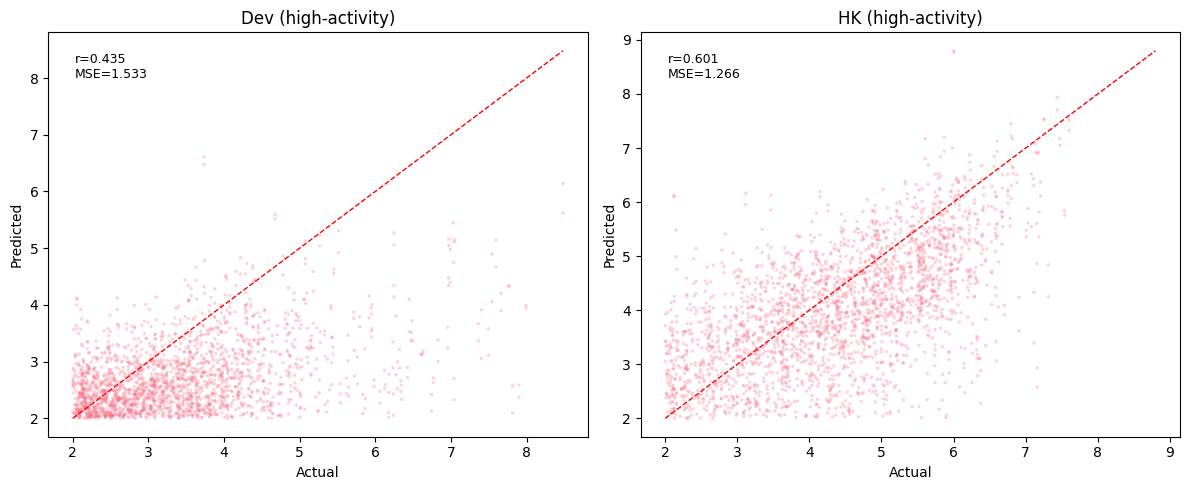

Saved: /grid/wsbs/home_norepl/pmantill/train_EvoAug/EvoAug_ensemble_10/pred_vs_actual_high_activity.svg


In [45]:
# Plot predicted vs actual for high-activity sequences (high-activity only)

import os
import numpy as np
import matplotlib.pyplot as plt

# Require high-activity DataFrames
assert 'high_dev_df' in globals() and 'high_hk_df' in globals(), "Run the high-activity cell first."

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def scatter_pred_vs_actual(ax, df, actual_col, pred_col, title):
    x = df[actual_col].values
    y = df[pred_col].values
    ax.scatter(x, y, s=6, alpha=0.3, edgecolor='none')
    vmin = float(min(x.min(), y.min()))
    vmax = float(max(x.max(), y.max()))
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=1)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(title)
    # Metrics annotation
    mse = np.mean((y - x) ** 2)
    r = np.corrcoef(x, y)[0, 1]
    ax.text(0.05, 0.95, f"r={r:.3f}\nMSE={mse:.3f}", transform=ax.transAxes,
            ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, linewidth=0))

scatter_pred_vs_actual(axes[0], high_dev_df, 'actual_dev', 'pred_dev', 'Dev (high-activity)')
scatter_pred_vs_actual(axes[1], high_hk_df, 'actual_hk', 'pred_hk', 'HK (high-activity)')

plt.tight_layout()
plot_path = os.path.join(output_dir, 'pred_vs_actual_high_activity.svg')
plt.savefig(plot_path, format='svg', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {plot_path}")

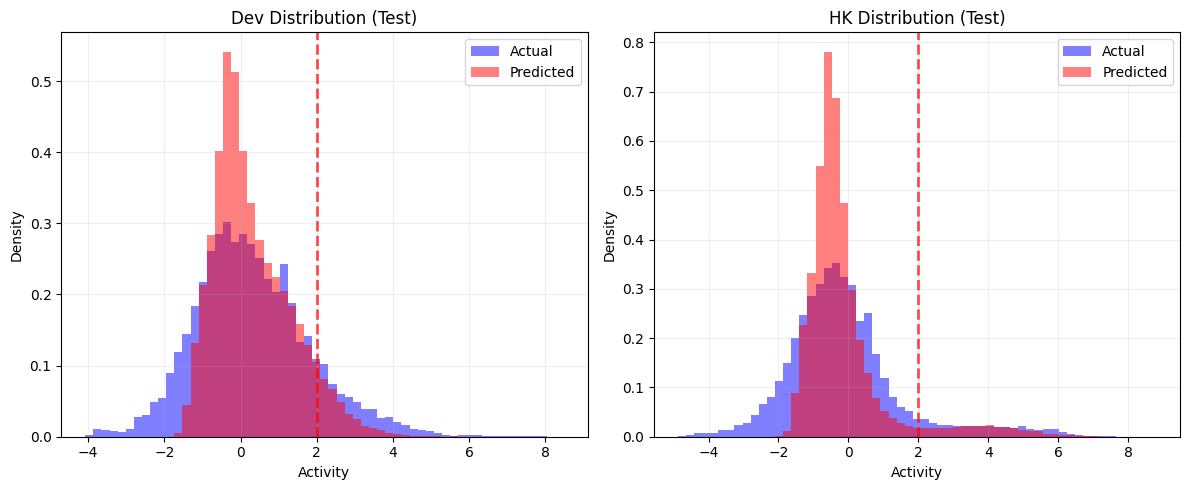

Saved: /grid/wsbs/home_norepl/pmantill/train_EvoAug/EvoAug_ensemble_10/activity_distribution.svg


In [51]:
# Plot distribution of activity (full test set)

import os
import numpy as np
import matplotlib.pyplot as plt

# Require full-test arrays
assert 'y_true' in globals() and 'y_pred' in globals(), "Run the metrics cell first to compute y_true/y_pred."

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Dev distribution
true_dev = y_true[:, 0]
pred_dev = y_pred[:, 0]
bins_dev = np.linspace(min(true_dev.min(), pred_dev.min()), max(true_dev.max(), pred_dev.max()), 60)
axes[0].hist(true_dev, bins=bins_dev, density=True, alpha=0.5, label='Actual', color='blue')
axes[0].hist(pred_dev, bins=bins_dev, density=True, alpha=0.5, label='Predicted', color='red')
axes[0].set_title('Dev Distribution (Test)')
axes[0].set_xlabel('Activity')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(alpha=0.2)

# HK distribution
true_hk = y_true[:, 1]
pred_hk = y_pred[:, 1]
bins_hk = np.linspace(min(true_hk.min(), pred_hk.min()), max(true_hk.max(), pred_hk.max()), 60)
axes[1].hist(true_hk, bins=bins_hk, density=True, alpha=0.5, label='Actual', color='blue')
axes[1].hist(pred_hk, bins=bins_hk, density=True, alpha=0.5, label='Predicted', color='red')
axes[1].set_title('HK Distribution (Test)')
axes[1].set_xlabel('Activity')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(alpha=0.2)
axes[0].axvline(2.0, color='r', linestyle='--', linewidth=2, alpha=0.7)
axes[1].axvline(2.0, color='r', linestyle='--', linewidth=2, alpha=0.7)

plt.tight_layout()
plot_path = os.path.join(output_dir, 'activity_distribution.svg')
plt.savefig(plot_path, format='svg', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {plot_path}")